## 📦 Loading the basic libraries required

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

## step 1. 📥📁 Loading the training data for processing

In [2]:
df=pd.read_csv("ANN_Challenge_Train_v1.csv")
df.describe()

,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Fault
count,3000.000000,3000.000000,3000.000000,3000.000000,2850.000000,3000.000000,3000.000000
mean,0.282350,-0.034925,0.386357,100.071609,10.033604,1.498571,0.200000
std,0.157657,0.975404,0.945288,29.898577,5.024830,1.516585,0.400067
min,0.003445,-3.179870,-3.001669,40.090238,-6.440784,0.000945,0.000000
25%,0.152271,-0.698720,-0.128212,74.223633,6.666244,0.426473,0.000000
50%,0.260383,-0.048992,0.405202,100.206000,10.017329,0.992030,0.000000
75%,0.394636,0.627771,1.008773,124.319254,13.603624,2.095111,0.000000
max,0.788990,3.280300,3.103201,179.859989,28.432520,12.117814,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sensor_1  3000 non-null   float64
 1   Sensor_2  3000 non-null   float64
 2   Sensor_3  3000 non-null   float64
 3   Sensor_4  3000 non-null   float64
 4   Sensor_5  2850 non-null   float64
 5   Sensor_6  3000 non-null   float64
 6   Fault     3000 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 164.2 KB


### No. of nulls in the given features (sensor_5): 150

In [4]:
df.isnull().sum()

Sensor_1      0
Sensor_2      0
Sensor_3      0
Sensor_4      0
Sensor_5    150
Sensor_6      0
Fault         0
dtype: int64

## 📊 Step 2: Visualization of Plots

### 🔍 Fault Label Distribution

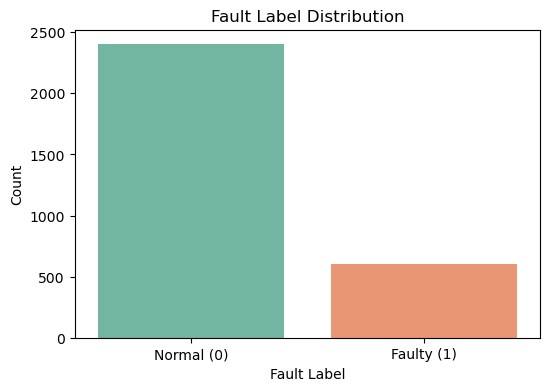

Fault
0    0.8
1    0.2
Name: proportion, dtype: float64

In [5]:
# Bar plot of fault and non-faulty machines
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Fault', hue='Fault', palette='Set2', legend=False)
plt.title("Fault Label Distribution")
plt.xticks([0, 1], ['Normal (0)', 'Faulty (1)'])
plt.ylabel("Count")
plt.xlabel("Fault Label")
plt.show()

# Show normalized class distribution
df['Fault'].value_counts(normalize=True)

### 📊 Sensor Distribution Plots

#### 💾 Storing the initial sensor columns before feature engineering

In [6]:
# Identify all sensor columns
sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]

# Create a new column as the product of all sensor values row-wise
df['Sensor_Product'] = df[sensor_cols].prod(axis=1)
sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]

#### 1. plot of orginal features



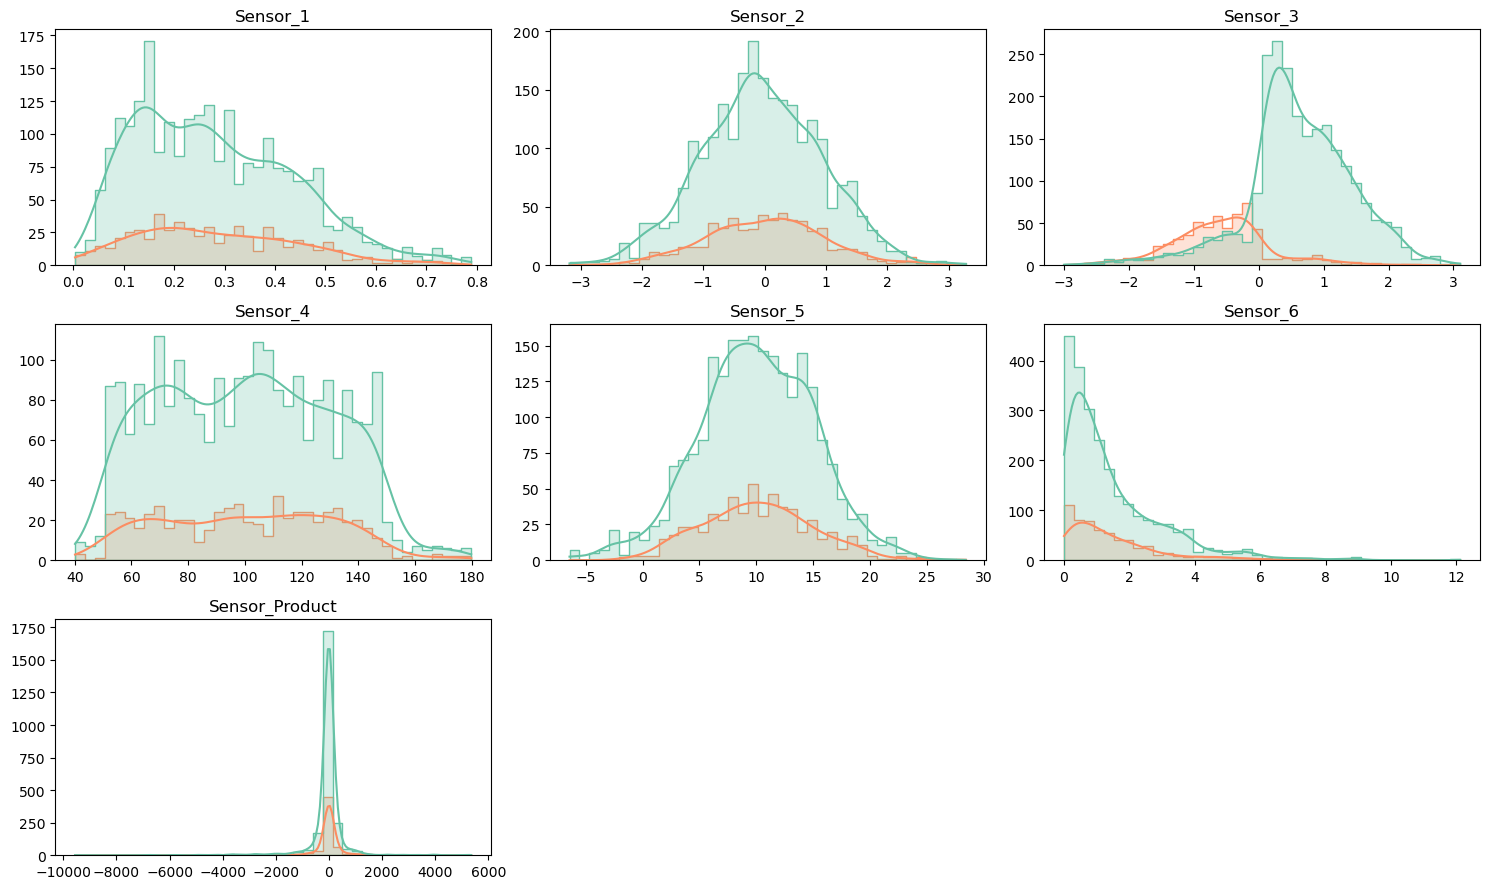

In [7]:
# Set the number of plots per row
n_cols = 3
n_rows = -(-len(sensor_cols) // n_cols)  # number of rows

plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=col, hue='Fault', kde=True, bins=40, element="step", palette='Set2', legend=False)
    plt.title(f"{col}")
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

#### 🛠️ Storing the Engineered Sensor Features

In [8]:
df['Sensor_1_minus_2'] = df['Sensor_1'] - df['Sensor_2']
df['Sensor_2_minus_3'] = df['Sensor_2'] - df['Sensor_3']
# delta

df['Sensor_1_div_2'] = df['Sensor_1'] / (df['Sensor_2'] + 1e-6)
# ratio

df['Sensor_1_sq'] = df['Sensor_1'] ** 2
df['Sensor_1_x_Sensor_2'] = df['Sensor_1'] * df['Sensor_2']
# polynomial

df['Sensor_product_log'] = np.log1p(df['Sensor_Product'])
# step cures fixing

for col in sensor_cols:
    df[f'{col}_zscore'] = (df[col] - df[col].mean()) / df[col].std()


sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]

C:\Users\Jeetu Modi\Desktop\Machine Learning\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### 2. plot after engineered Sensor features

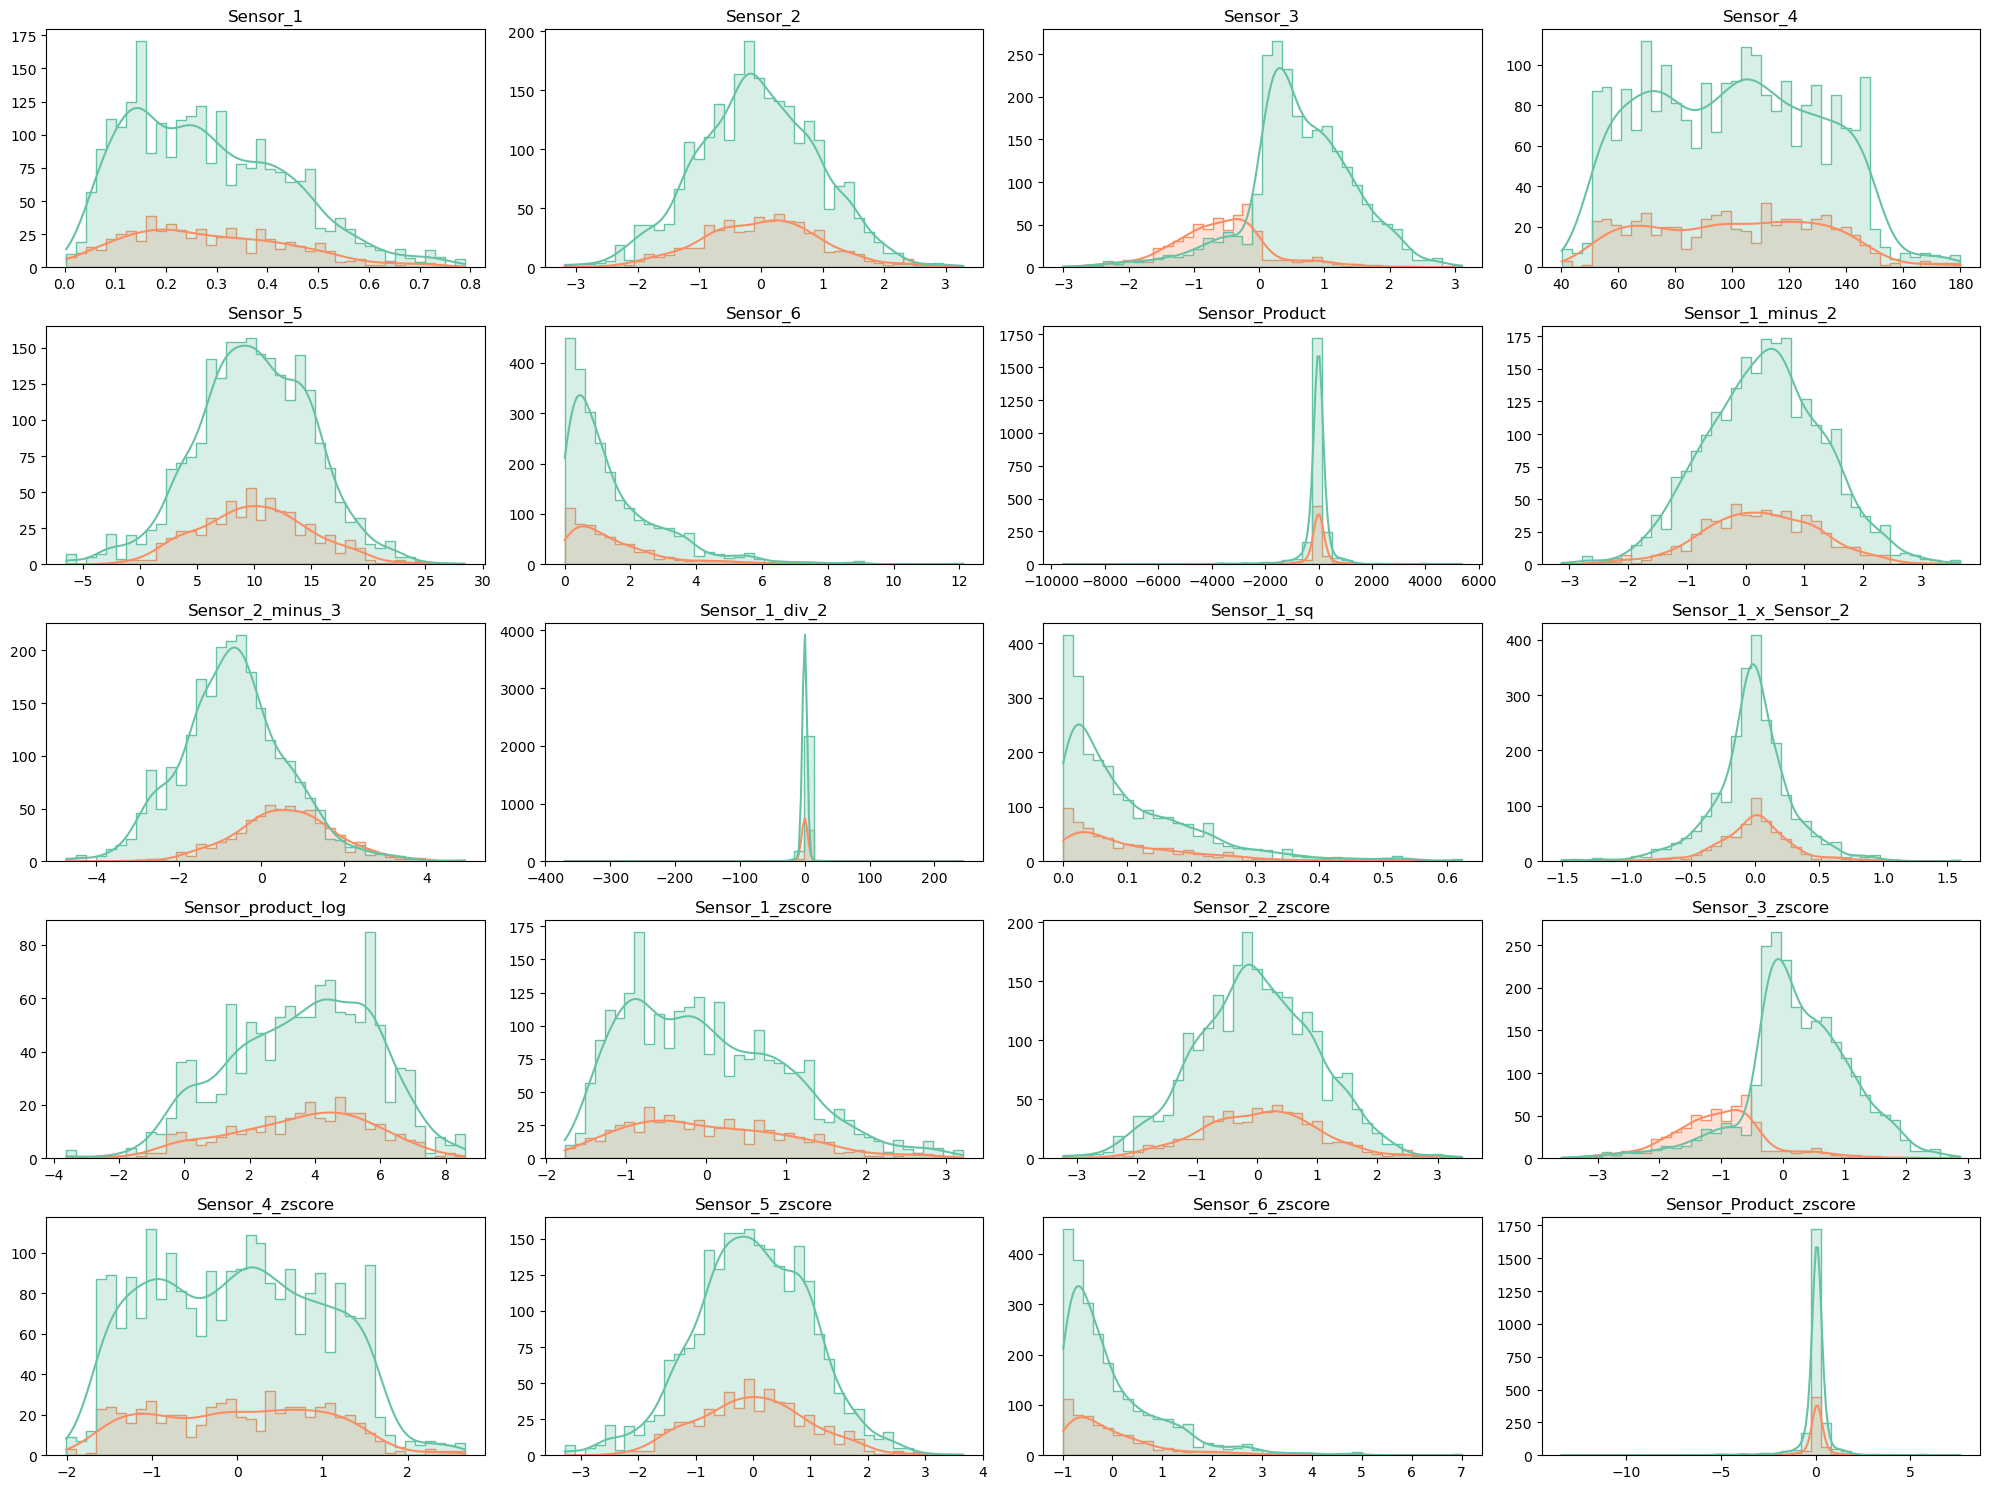

In [9]:
# Set the number of plots per row
n_cols = 4
n_rows = -(-len(sensor_cols) // n_cols)  # Ceiling division to get the number of rows

plt.figure(figsize=(n_cols * 5, n_rows * 3))  # Customize the overall figure size

for i, col in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=col, hue='Fault', kde=True, bins=40, element="step", palette='Set2', legend=False)
    plt.title(f"{col}")
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

### 📈 Sensor Correlation Heatmap

In [10]:
def heatmap(sensor_cols):# printing heatmap
    plt.figure(figsize=(8, 6))
    corr = df[sensor_cols + ['Fault']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title("Correlation Matrix (Sensors + Fault)")
    plt.show()

#### selecting the best features

In [11]:
best_features = [
    'Sensor_1_zscore', 'Sensor_2_zscore', 'Sensor_3_zscore',
    'Sensor_4_zscore', 'Sensor_5_zscore', 'Sensor_6_zscore',
     'Sensor_1_x_Sensor_2',
    'Sensor_1_sq', 'Sensor_product_log',
]

#### Heatmap

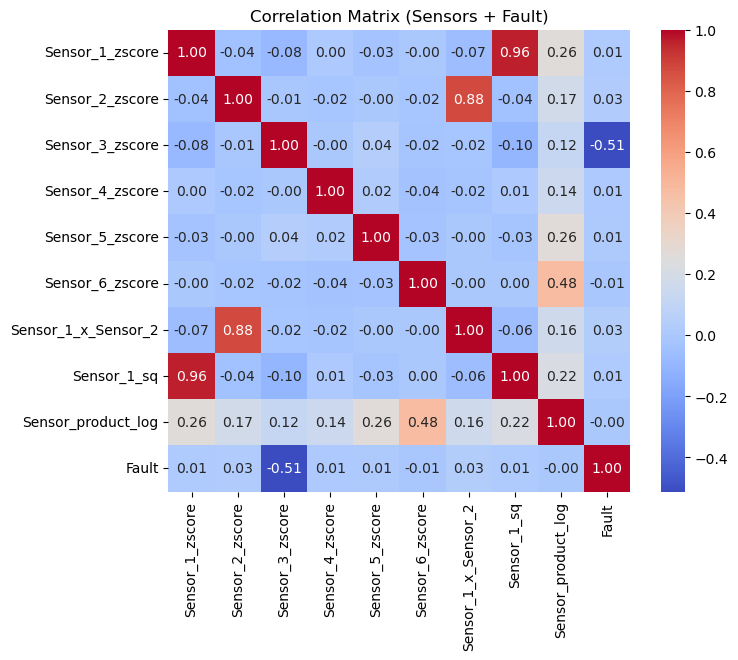

In [12]:
heatmap(best_features)

## 🧪 Step 3: Preparing Data for Training and Testing

### 🧼 Fixing Empty/Null Values with Median Imputation

In [13]:
train_data_imputed = df.copy()
for col in best_features:
    train_data_imputed[col] = train_data_imputed[col].fillna(train_data_imputed[col].median())

### ✅ Feature Selection

In [14]:
selected_features={
    'Sensor_3_zscore',
    'Sensor_2_zscore',
    'Sensor_5_zscore',
    'Sensor_1_x_Sensor_2',
}

# Select features for scaling
X = train_data_imputed[best_features]
y = train_data_imputed['Fault']

### 🔄 Feature Scaling|

In [15]:
# Initialize scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 🔀 Train-Test Split

In [16]:
# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### ⚖️ Handling the Imbalance of Class Weights

In [17]:
# Compute class weights to handle imbalance
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

## 🤖 Step 4: Model Training and Testing

### 🏋️ Model Training

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.15),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.05),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with Adam optimizer
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.summary()


C:\Users\Jeetu Modi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,297 (716.00 KB)

 Trainable params: 181,505 (709.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

### ⏱️ Callbacks During Model Training

In [19]:
# Callbacks
early_stop = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)

# Train
history = model.fit(
    X_resampled, y_resampled,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7433 - loss: 1.1812 - val_accuracy: 0.8233 - val_loss: 1.1093 - learning_rate: 0.0010
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8400 - loss: 1.0015 - val_accuracy: 0.8300 - val_loss: 0.9742 - learning_rate: 0.0010
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8535 - loss: 0.9110 - val_accuracy: 0.8483 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8539 - loss: 0.8463 - val_accuracy: 0.8600 - val_loss: 0.8219 - learning_rate: 0.0010
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.7662 - val_accuracy: 0.8717 - val_loss: 0.7537 - learning_rate: 0.0010
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8589 - loss: 0.7354 - val_accuracy: 0.8400 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8643 - loss: 0.

### 🧪 Model Testing

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


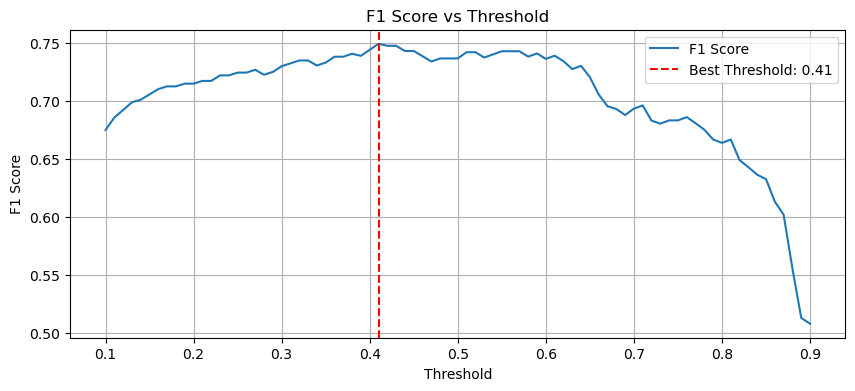

🔍 Best Threshold: 0.41
✅ F1 Score:       0.7491
📌 Precision:      0.6503
📌 Recall:         0.8833
📌 ROC AUC:        0.9109


In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities
y_val_probs = model.predict(X_val).ravel()

# Try multiple thresholds to find best F1
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = [f1_score(y_val, y_val_probs >= t) for t in thresholds]

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot F1 vs Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

# Final classification with best threshold
y_val_pred = (y_val_probs >= best_threshold).astype(int)

# Show metrics
print(f"🔍 Best Threshold: {best_threshold:.2f}")
print(f"✅ F1 Score:       {f1_score(y_val, y_val_pred):.4f}")
print(f"📌 Precision:      {precision_score(y_val, y_val_pred):.4f}")
print(f"📌 Recall:         {recall_score(y_val, y_val_pred):.4f}")
print(f"📌 ROC AUC:        {roc_auc_score(y_val, y_val_probs):.4f}")


# 📍 Predictions on Test Data

In [22]:
# Load test data
test_data = pd.read_csv("ANN_Challenge_Test_with_ID_v1.csv")

# Sensor columns
sensor_cols = [col for col in test_data.columns if col.startswith("Sensor_")]

# Sensor product
test_data['Sensor_Product'] = test_data[sensor_cols].prod(axis=1)

# Delta features
test_data['Sensor_1_minus_2'] = test_data['Sensor_1'] - test_data['Sensor_2']
test_data['Sensor_2_minus_3'] = test_data['Sensor_2'] - test_data['Sensor_3']

# Ratio feature
test_data['Sensor_1_div_2'] = test_data['Sensor_1'] / (test_data['Sensor_2'] + 1e-6)

# Polynomial features
test_data['Sensor_1_sq'] = test_data['Sensor_1'] ** 2
test_data['Sensor_1_x_Sensor_2'] = test_data['Sensor_1'] * test_data['Sensor_2']

# Log transform (safe version)
sensor_product_clipped = test_data['Sensor_Product'].clip(lower=0)
test_data['Sensor_product_log'] = np.log1p(sensor_product_clipped)

# Z-score features using train_data_imputed mean & std
for col in sensor_cols + ['Sensor_Product']:
    mean = train_data_imputed[col].mean()
    std = train_data_imputed[col].std()
    test_data[f'{col}_zscore'] = (test_data[col] - mean) / std

# Ensure all training features are present
for col in best_features:
    if col not in test_data.columns:
        test_data[col] = 0  # or fill with median later

# Fill missing with training medians
for col in best_features:
    test_data[col] = test_data[col].fillna(train_data_imputed[col].median())

# Final transformation using trained scaler
X_test = scaler.transform(test_data[best_features])


# Predict probabilities on hidden test set
test_probs = model.predict(X_test).ravel()

# Apply tuned threshold
test_preds = (test_probs >= best_threshold).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Predicted_Label': test_preds
})

# Save submission file
submission.to_csv("model.csv", index=False)

print("Submission file saved as: model.csv")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Submission file saved as: model.csv
